## Este codigo es para el diseno de ataques

### Librerías necesarias

In [208]:
from os.path import join
from matplotlib.image import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Definición de rutas

In [209]:
data_path = 'D:\MaIE\Semestre3\RL\Data\TrafficSignals'
models_path = 'models'
train_data_path = 'D:\MaIE\Semestre3\RL\Data\TrafficSignals\Train'
labels_path = 'D:\MaIE\Semestre3\RL\Data\TrafficSignals\Test.csv'

### Cargar imágenes de testeo

In [210]:
data = []
labels = []
Table = pd.read_csv(labels_path)
Table['Path']
for j in range(0,Table['Path'].shape[0]):
    ima_path =join(data_path, Table['Path'][j])
    imagen = imread(ima_path,-1)
    imagen = resize(imagen,(32,32))
    data.append(imagen)
    labels.append(Table['ClassId'][j])

In [211]:
data2 = np.array(data)
labels2 = np.array(labels)
print(data2.shape,labels2.shape)

(12630, 32, 32, 3) (12630,)


In [212]:
X_test = data2
y_test = labels2

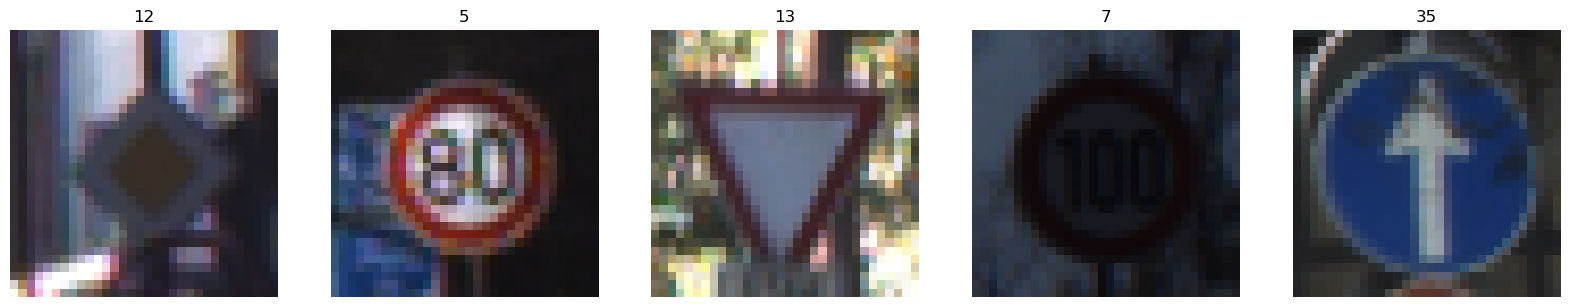

In [213]:
test_images = [X_test[10], X_test[30], X_test[26], X_test[40],  X_test[9]]
test_labels = [y_test[10], y_test[30], y_test[26], y_test[40], y_test[9]]
plt.figure(figsize=(20, 10))
for i in range(5):
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(test_images[i])
      plt.title(test_labels[i])
      plt.axis("off")

In [214]:
class AttackModel():
    def __init__(self, model, images, epsilons):
        self.model = model
        self.images = images
        self.epsilons = epsilons
        
    def predict(self, image):
        ref = np.argmax(self.model(image))
        return tf.constant(to_categorical(ref, 43).reshape(1, 43))
    
    def get_adversarial_image(self, image, epsilon, target=None, pixel_number = None):
        image = tf.cast(image.reshape(1, 32, 32, 3), tf.float32)
        if target is None:
            label = self.predict(image)
        else:
            label = tf.constant(to_categorical(target, 43).reshape(1, 43))
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.model(image)
            loss = CategoricalCrossentropy()(label, prediction)
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        disturbance = signed_grad[0] * 0.5 + 0.5 

        if pixel_number is not None:
            pixels_to_perturb = np.random.choice(range(32*32), size=pixel_number, replace=False)
            signed_grad_pixels = np.zeros((32, 32, 3))
            for p in pixels_to_perturb:
                x, y = p % 32, p // 32
                signed_grad_pixels[x, y, :] = signed_grad[0, x, y, :]
            adversarial_image = (image + epsilon * signed_grad_pixels) if target is None else (image - epsilon * signed_grad_pixels )
            y_disturbance = np.argmax(self.model(adversarial_image))
            disturbance_pixels = signed_grad_pixels * 0.5 + 0.5
            return adversarial_image, y_disturbance, disturbance_pixels

        adversarial_image = (image + epsilon * signed_grad) if target is None else (image - epsilon * signed_grad)
        y_disturbance = np.argmax(self.model(adversarial_image))
        return adversarial_image, y_disturbance, disturbance
    
    def get_adversarial_images(self, targets=None, pixel_number = None):
        adv_images = []
        adv_labels = []
        adv_disturbances = []
        for i in range(len(self.images)):
            adv_image, adv_label, adv_disturbance = self.get_adversarial_image(
                self.images[i], self.epsilons[i], targets[i] if targets else None, pixel_number)
            adv_images.append(adv_image)
            adv_labels.append(adv_label)
            adv_disturbances.append(adv_disturbance)
        return np.array(adv_images), np.array(adv_labels), np.array(adv_disturbances)


# 1. Untargeted attack

### Modelo Andres-Ernesto

In [215]:
epsilons = [0.0058, 0.008, 0.013, 0.0009, 0.06]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[30  3 15  8 39]


### Modelo Donovan-Jorge

In [216]:
epsilons = [0.0077, 0.0038, 0.039, 0.0018, 0.047]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[30  3 35  4 13]


### Modelo profesor

In [311]:
epsilons = [0.047, 0.047, 0.49, 0.013, 0.087]
attack_model = AttackModel(load_model(join(models_path, 'teacher.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[38  6 33  4  9]


# 2. Target attack

### Modelo Andres-Ernesto

In [218]:
epsilons = [0.037, 0.044, 0.064, 0.015, 0.045]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[11  4 12  6 34]


### Modelo Donovan-Jorge

In [312]:
epsilons = [0.041, 0.03, 0.046, 0.011, 0.055]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[11  4 12  6 34]


### Modelo profesor

In [359]:
epsilons = [0.041, 0.074, 0.077, 0.0064, 0.019]
attack_model = AttackModel(load_model(join(models_path, 'teacher.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[11  4 42  6 34]


## 3. Modificar 10 pixeles

### Modelo Andres-Ernesto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[18  3 12  5 36]


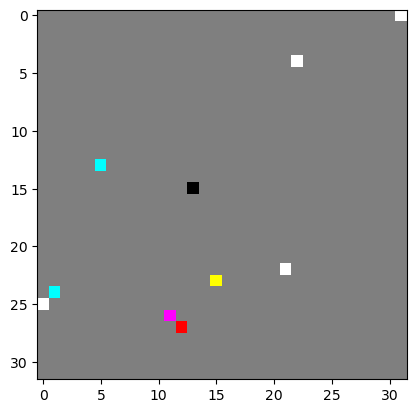

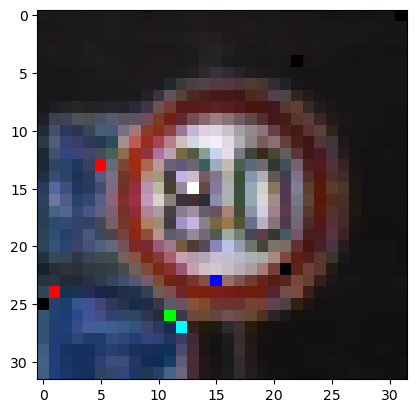

In [220]:
epsilons = [2.5, 4, 5.5, 2.5, 5.5]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
targets = [test_labels[i] - 1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets, pixel_number=10)

print(test_labels)
print(adv_labels)
plt.imshow(adv_disturbances[1])
plt.figure()
plt.imshow(adv_images[1].reshape(32, 32, 3))

### Modelo Donovan-Jorge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[ 4  4 13 25 35]


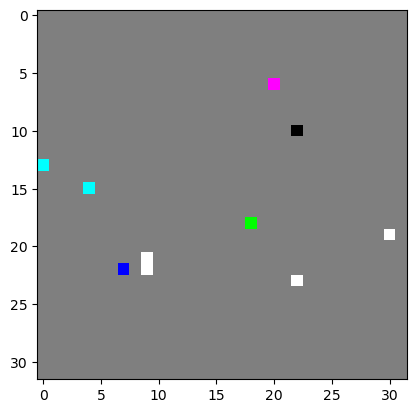

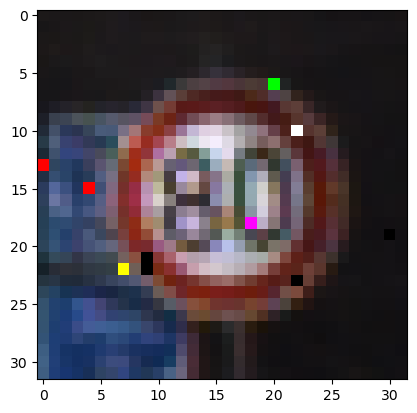

In [221]:
epsilons = [3.5, 4, 4.5, 2.5, 5.5]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
targets = [test_labels[i] - 1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets, pixel_number=10)

print(test_labels)
print(adv_labels)
plt.imshow(adv_disturbances[1])
plt.figure()
plt.imshow(adv_images[1].reshape(32, 32, 3))